In [1]:
#@title **Install & Import**
# !pip install tensorflow_io
# !!pip install transformers -q

import tensorflow as tf
import tensorflow_io as tfio
import os
import glob
import matplotlib.pyplot as plt
import tifffile
from tqdm import tqdm
import pickle
from transformers import TFSegformerForSemanticSegmentation
import pandas as pd

from PIL import Image
import cv2
import numpy as np

# tf.config.list_physical_devices('GPU') #Check GPU
# from google.colab import drive #grive
# drive.mount('/content/drive', force_remount=True)

2024-02-22 14:50:18.444875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 14:50:18.445024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 14:50:18.731936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pickle
path = '/kaggle/input/train-test-split-and-norm-statistics/'
with open(path +'subset_for_comparison.pkl', 'rb') as f:
    files = pickle.load(f)

In [3]:
# load pickled mean and standard deviation into lists
# path = defined previously
with open(path + 'pickles/mean_ofpixels_perfeature.pkl', 'rb') as f:
    mean = tf.constant(pickle.load(f))

with open(path + 'pickles/std_ofpixels_perfeature.pkl', 'rb') as f:
    std_dev = tf.constant(pickle.load(f))
print('Mean', mean)
print('Variance', std_dev**2)

Mean tf.Tensor(
[1.76531177e+03 3.78603119e+02 4.94143372e+01 1.57476425e+02
 3.16769848e+01 3.70530438e+00 6.18160105e+00 2.20388174e-01
 1.00450516e+02], shape=(9,), dtype=float32)
Variance tf.Tensor(
[7.6581060e+06 4.5924769e+05 1.1981212e+06 1.1568138e+05 3.1951895e+02
 3.2285776e+02 2.3181917e+02 2.4716029e-01 9.4055342e+03], shape=(9,), dtype=float32)


In [ ]:
files

In [4]:
batch_size = 8
#epochs = 50
auto = tf.data.AUTOTUNE
# Paths to your data directories
images_dir = r"/kaggle/input/track1/Track1/train/images/"
labels_dir = r"/kaggle/input/track1/Track1/train/labels/"
image_size = 512

In [5]:
#inference
model_checkpoint = "rparasa/" +'sf_20240220_v2'
model = TFSegformerForSemanticSegmentation.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at rparasa/sf_20240220_v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [7]:
def parse_image(file_path):
    image = tf.convert_to_tensor(np.array(tifffile.imread(file_path)))
    return image
def parse_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [image_size, image_size], method='nearest')
    mask = tf.squeeze(mask)  # Ensure it's a 2D tensor for the mask
    mask.set_shape([image_size, image_size])
    return mask

def test_load_and_preprocessdata(image_path, mean, std_dev): #, 
    image = parse_image(image_path)
    image = tf.transpose(image, (2, 0, 1))  # Adjust dimensions if necessary

    # preprocessing pipeline
    image = np.concatenate([image, np.zeros_like(image[:3, :, :])], axis=0)
    image = calc_vv_vh(image)    #add vv/vh
    image = calc_dem_lc(image)  #add dem + lc
    image = calc_dist_transform(image)    #add distance transform
    image = calc_norm(image, mean, variance=std_dev**2, axis=0)   #normalize image

    #drop features not required
    channels_to_keep = [0,1,2,3,5,6,7,8] 
    modified_image = tf.gather(image, channels_to_keep, axis=0)
    return {"pixel_values": modified_image}

def calc_vv_vh(image):
    denominator = image[1, :, :]
    image[6, :, :] = np.nan_to_num(np.divide(image[0, :, :], denominator), nan=0)
    return image

def calc_dem_lc(image):
    dem_quantile = np.where(image[2,:,:] <= np.quantile(image[2,:,:],0.1), 1, 0)
    binary_image = np.where(image[4,:,:] >= 80, 1, 0)
    image[7, :, :] = np.sum([dem_quantile, binary_image], axis=0)
    return image

def calc_dist_transform(image):
    #print(np.min(image[4, :, :]),np.max(image[4, :, :]) )
    binary_image = np.where(image[4, :, :] >= 80, 0,1).astype(np.uint8)
    #print(np.min(binary_image), np.max(binary_image))
    dist = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
    image[8, :, :] = dist
    return image

def calc_norm(image, mean, variance, axis):
    layer = tf.keras.layers.Normalization(axis=axis, mean=mean, variance=variance, invert=False)
    image = layer(image)
    return image

# def get_image_mask_paths(images_dir, labels_dir):
#     image_paths = sorted([os.path.join(images_dir, fname) for fname in sorted(os.listdir(images_dir))])
#     mask_paths = sorted([os.path.join(labels_dir, fname) for fname in sorted(os.listdir(labels_dir))])
#     return image_paths, mask_paths

# def test_get_image_mask_paths(images_dir): # we use a different function for ths purpose in this notebook
#     fnames = sorted(os.listdir(images_dir))
#     image_paths = sorted([os.path.join(images_dir, fname) for fname in fnames])
#     return image_paths, fnames

# def image_mask_generator(image_paths, mask_paths):
#     for img_path, mask_path in zip(image_paths, mask_paths):
#         yield load_data(img_path, mask_path)

def test_image_mask_generator(image_paths, mean, std_dev):
    for img_path in image_paths:
        yield test_load_and_preprocessdata(img_path, mean, std_dev)

def test_prepare_for_training(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=auto)
    return ds

# wrap up upsampling and argmax in a function
def upsampled_and_argmax(predictions):
    upsampled = tf.keras.layers.UpSampling2D(size=(4,4), data_format="channels_first",
                                           interpolation='bilinear')(predictions.logits)
    labels = np.argmax(upsampled, axis=1)
    return labels

def argmax(predictions):
    labels = np.argmax(predictions.logits, axis=1)
    return labels

# save in files
def save_numpy_arrays_as_images(numpy_arrays, target_folder, file_names):
    # Create the target folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)
    for i, array in enumerate(numpy_arrays):
        array = array.astype(np.uint8)
        image = Image.fromarray(array)

        # Save the image to the target folder with a filename based on the index
        new_fl = file_names[i].replace(".tif", ".png")
        image_path = os.path.join(target_folder, new_fl)
        image.save(image_path)
    print('Inference images saved successfully.')
    #return None

In [8]:
def get_image_mask_paths(images_dir, images_names):
    image_paths = sorted([os.path.join(images_dir, fname) for fname in sorted(images_names)])
    #mask_paths = sorted([os.path.join(labels_dir, fname) for fname in sorted(labels_names)])
    return image_paths, sorted(images_names)

In [9]:
### LOAD DATA ###
test_images_dir = r"/kaggle/input/track1/Track1/train/images/"
test_image_paths, file_names = get_image_mask_paths(test_images_dir, files)

# Creating the dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_image_mask_generator(test_image_paths, mean, std_dev),
    output_types={'pixel_values': tf.float32},
    output_shapes={'pixel_values': (8, image_size, image_size)}
)

test_dataset = test_prepare_for_training(test_dataset, cache = False)

# # Prefetch for performance optimization
test_dataset = test_dataset.prefetch(auto)
num_steps = len(test_image_paths) // batch_size  # Assuming batch_size is defined
test_num_steps = num_steps + 1 if len(test_image_paths) % batch_size != 0 else num_steps

In [10]:
file_names

['1001.tif',
 '1032.tif',
 '1033.tif',
 '1101.tif',
 '1106.tif',
 '1178.tif',
 '1188.tif',
 '1206.tif',
 '1232.tif',
 '1254.tif',
 '1331.tif',
 '142.tif',
 '1443.tif',
 '1464.tif',
 '1519.tif',
 '1560.tif',
 '1571.tif',
 '1593.tif',
 '1615.tif',
 '242.tif',
 '3.tif',
 '302.tif',
 '338.tif',
 '386.tif',
 '473.tif',
 '474.tif',
 '518.tif',
 '614.tif',
 '67.tif',
 '725.tif',
 '735.tif',
 '784.tif',
 '802.tif',
 '809.tif',
 '887.tif',
 '899.tif',
 '908.tif',
 '920.tif',
 '930.tif',
 '943.tif']

In [11]:
predictions = model.predict(test_dataset, steps =test_num_steps)
labels = upsampled_and_argmax(predictions)
print(len(predictions.logits)) # should be 349
print(len(labels))

/tmp/ipykernel_34/3234517245.py:30: RuntimeWarning: divide by zero encountered in divide
  image[6, :, :] = np.nan_to_num(np.divide(image[0, :, :], denominator), nan=0)
/tmp/ipykernel_34/3234517245.py:30: RuntimeWarning: invalid value encountered in divide
  image[6, :, :] = np.nan_to_num(np.divide(image[0, :, :], denominator), nan=0)
/tmp/ipykernel_34/3234517245.py:30: RuntimeWarning: invalid value encountered in cast
  image[6, :, :] = np.nan_to_num(np.divide(image[0, :, :], denominator), nan=0)
I0000 00:00:1708613711.453634     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 17s 197ms/step
40
40


In [12]:
save_numpy_arrays_as_images(labels,r"/kaggle/working/subset_segformerpreds", file_names)

Inference images saved successfully.


In [23]:
labels_2 = argmax(predictions)

In [24]:
print(len(labels_2))

40


/tmp/ipykernel_34/2875440350.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2, figsize = (10,10))


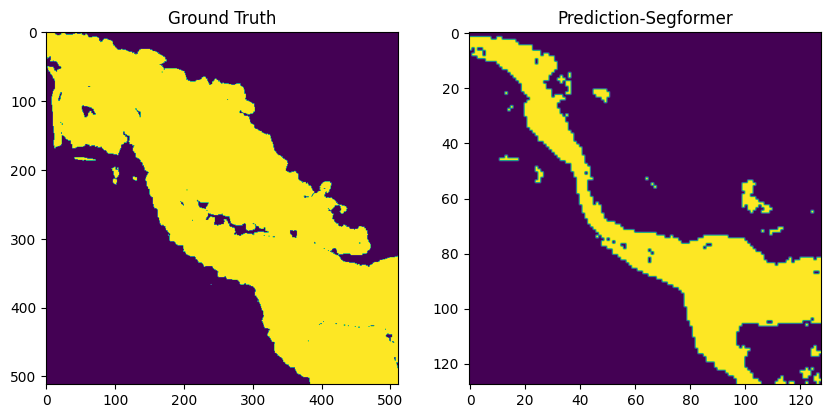

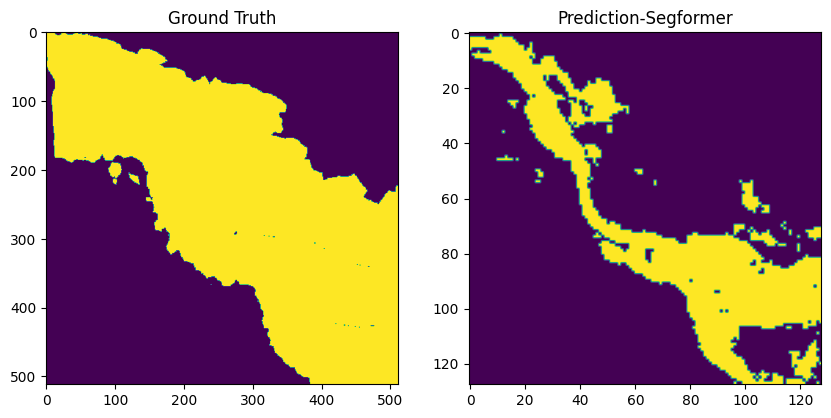

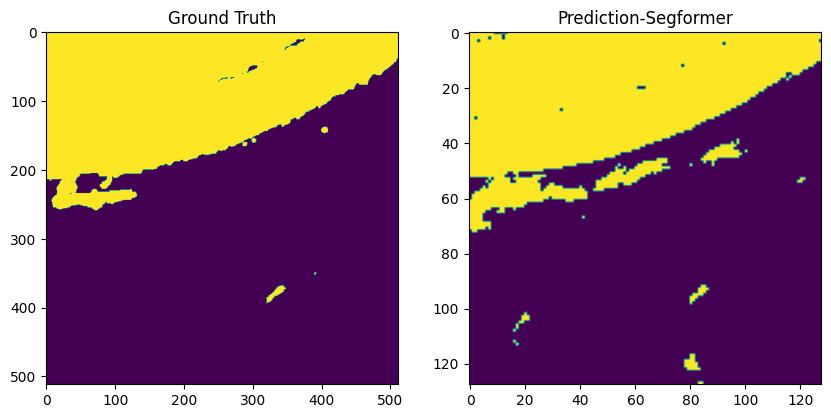

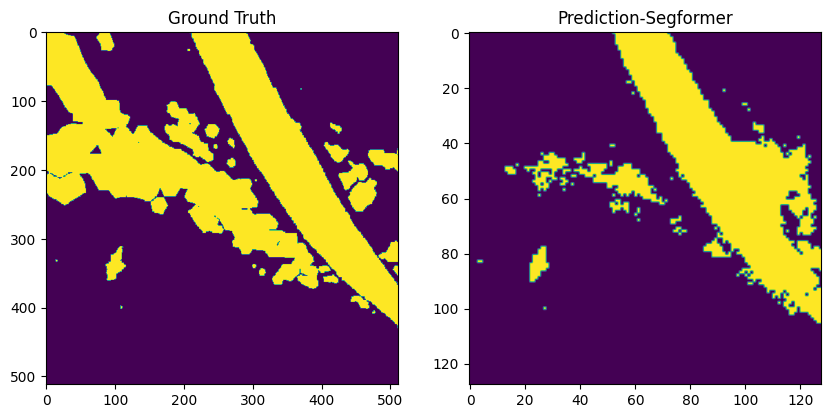

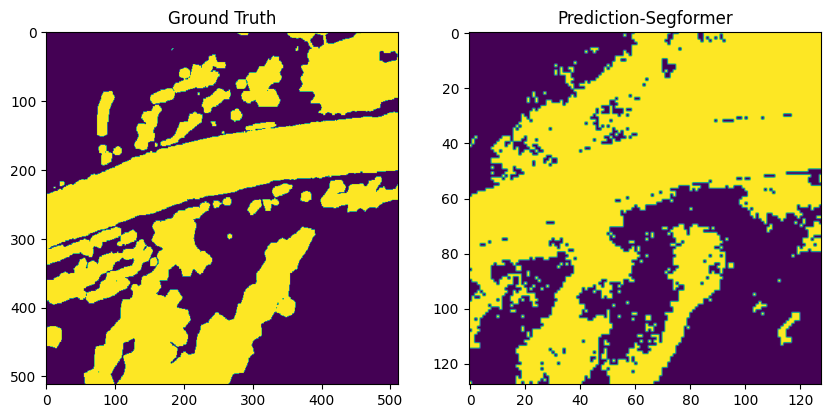

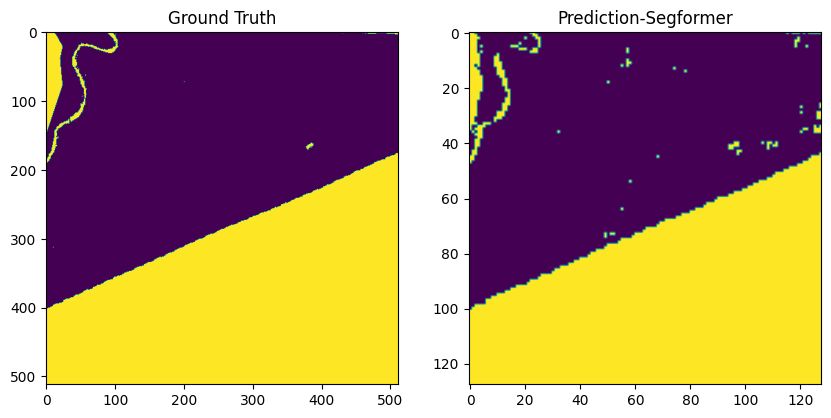

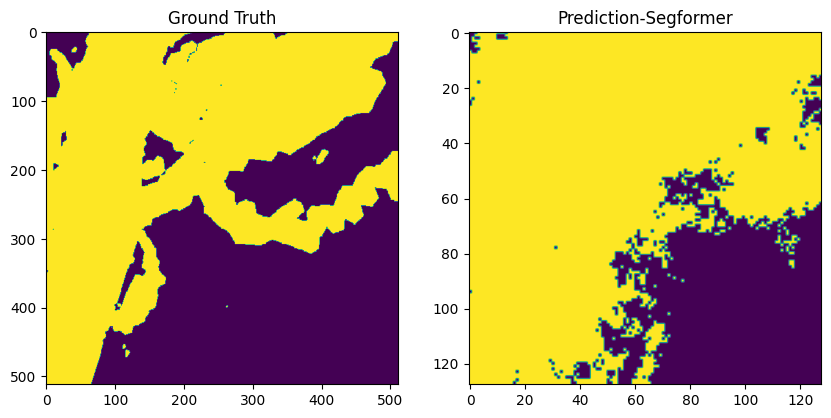

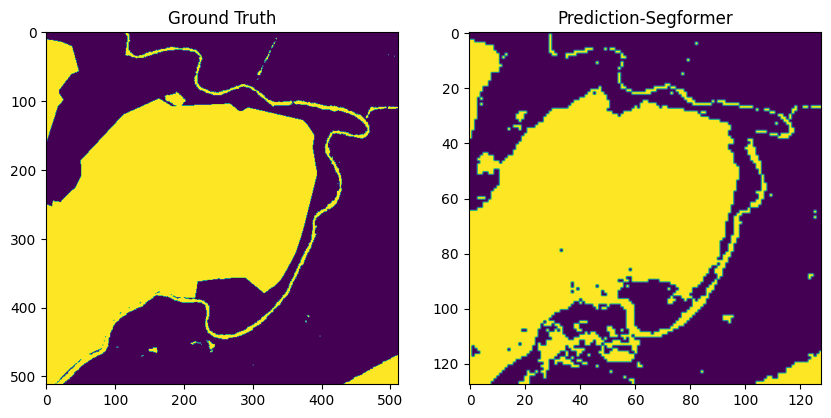

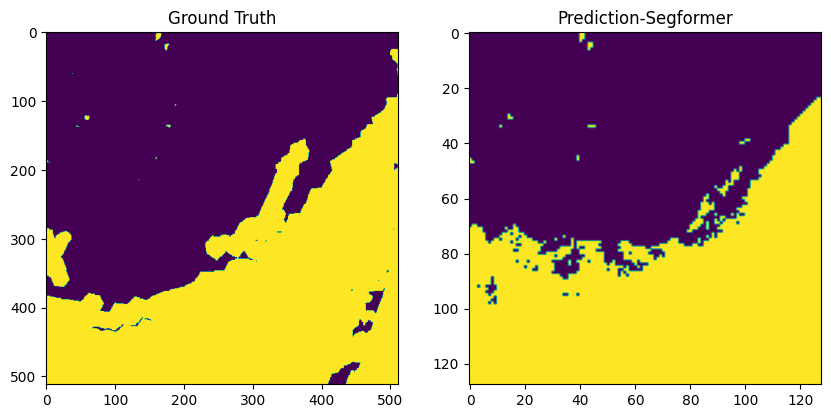

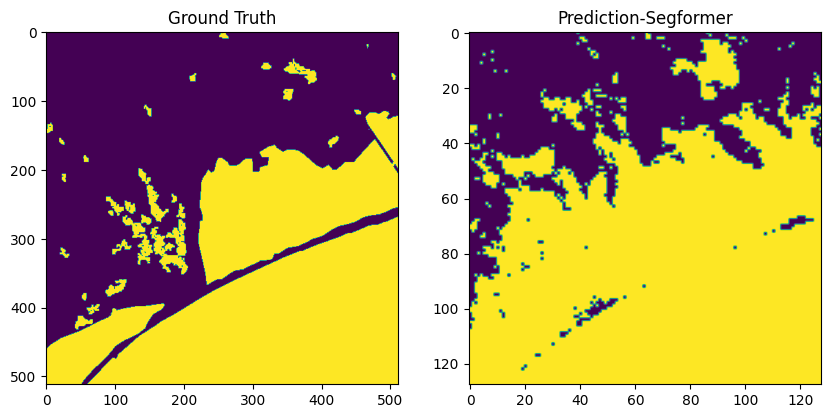

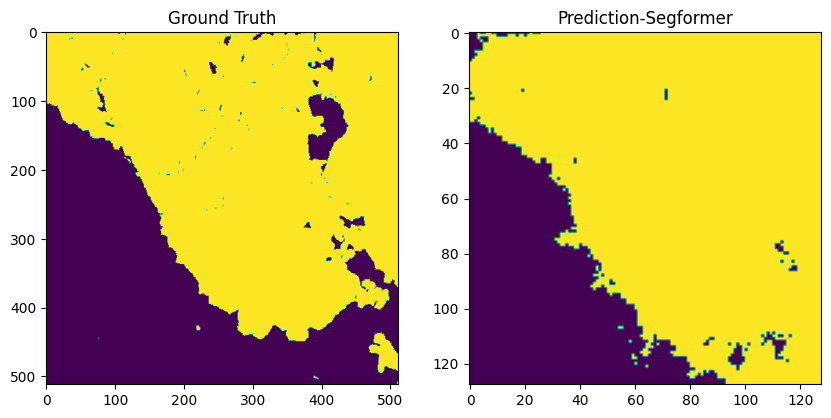

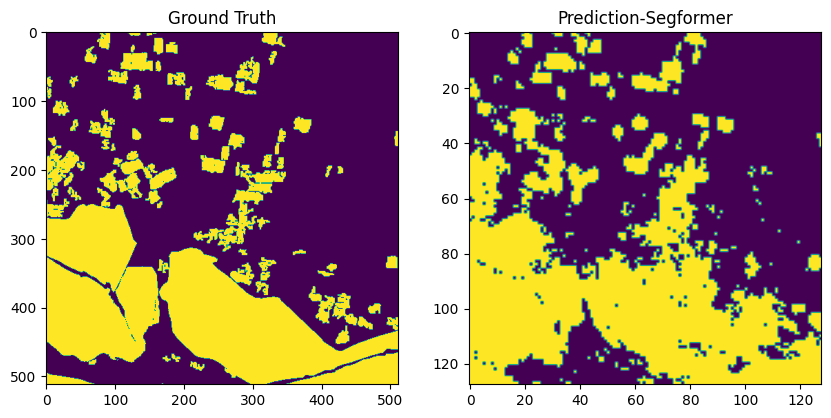

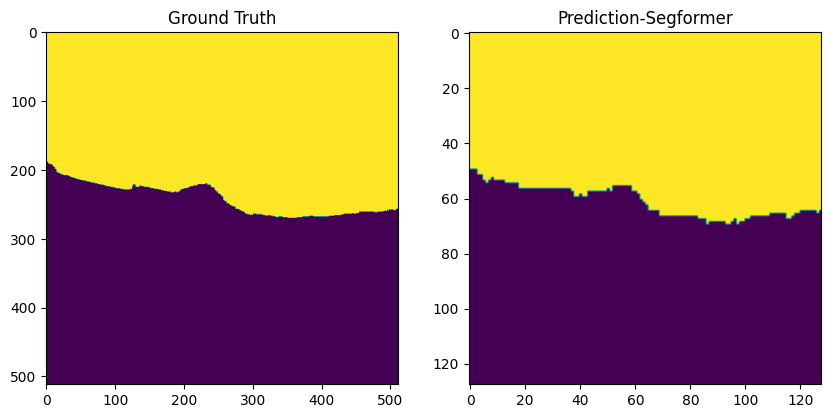

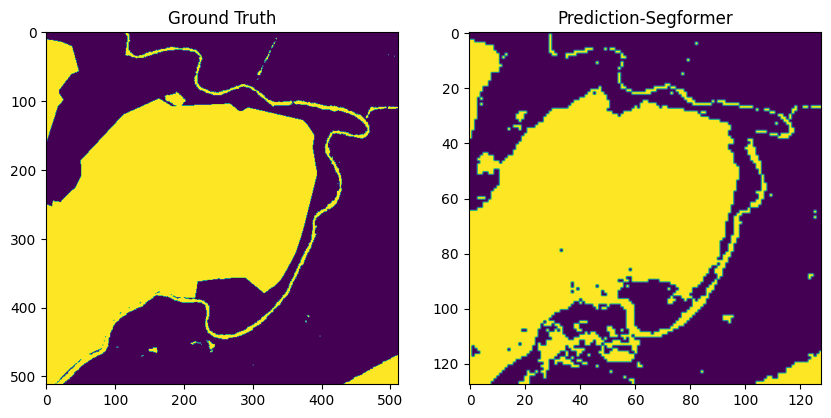

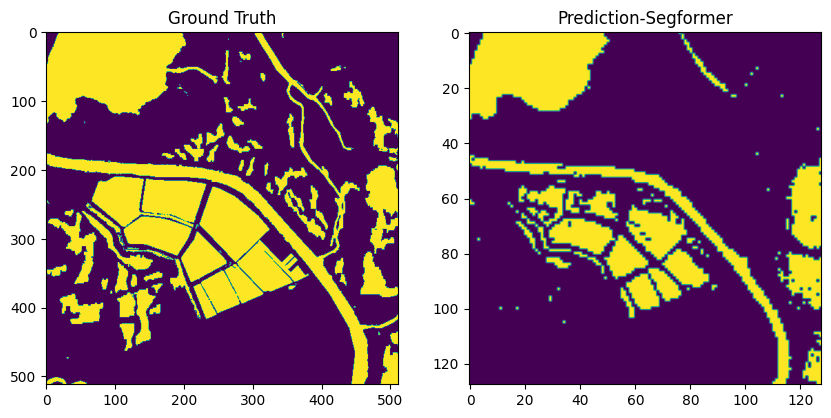

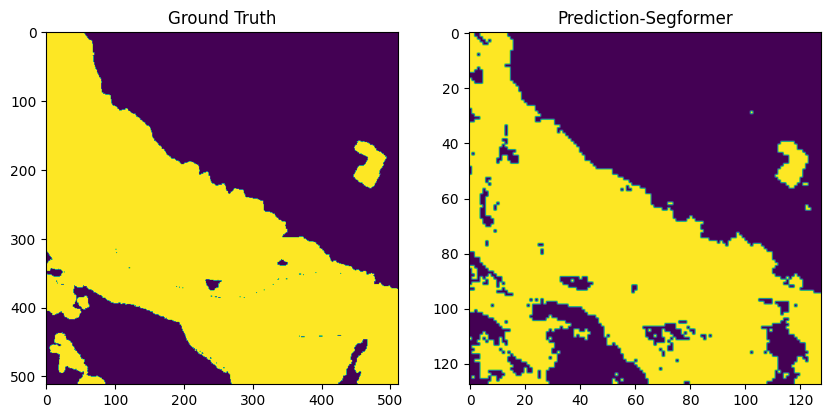

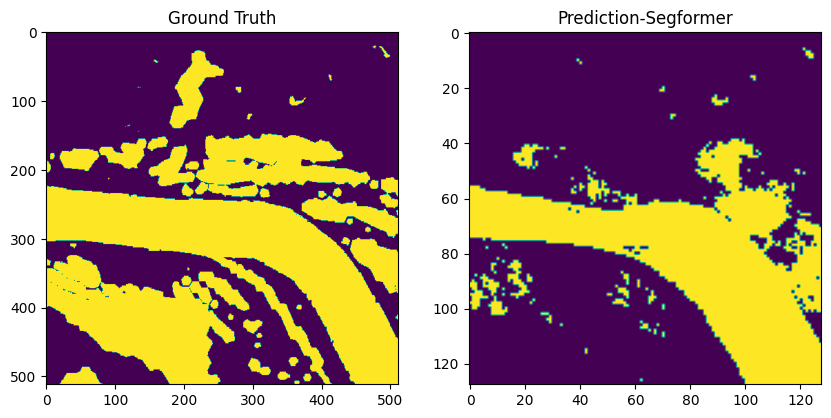

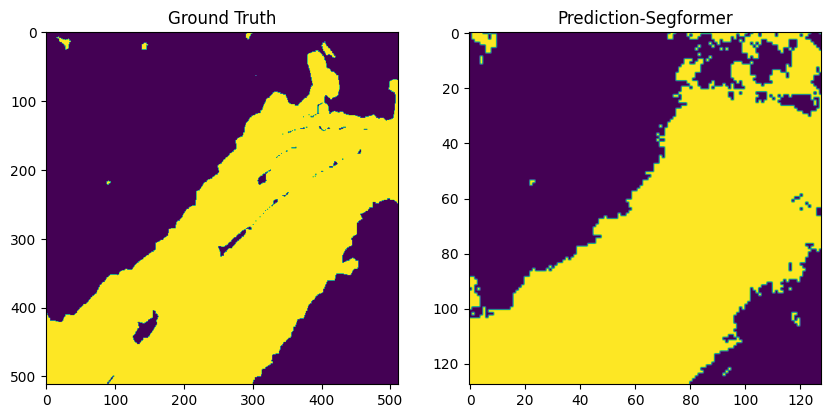

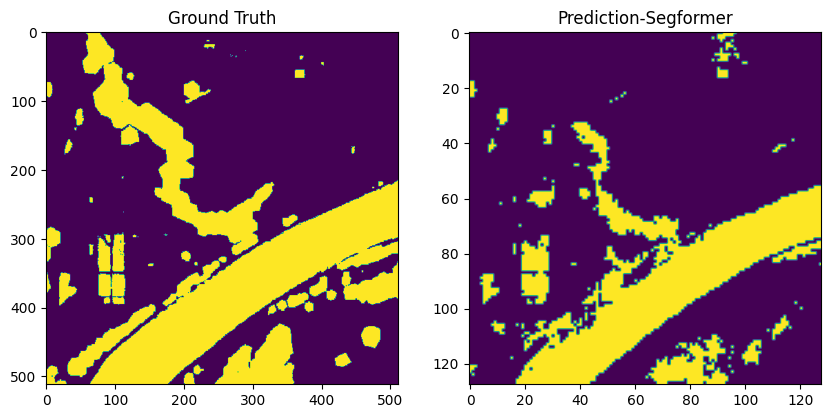

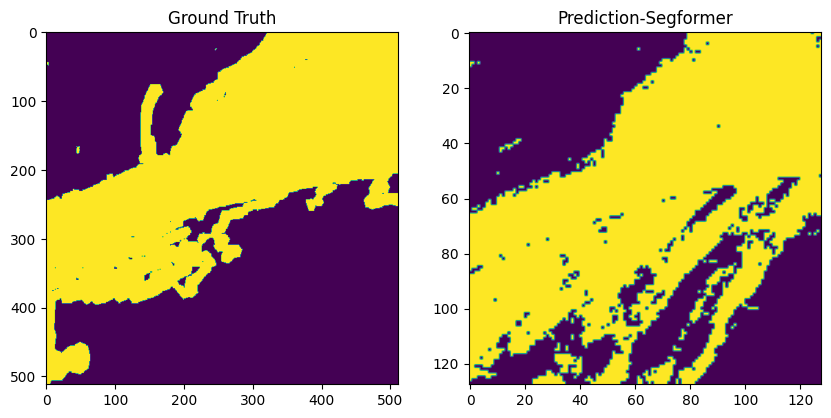

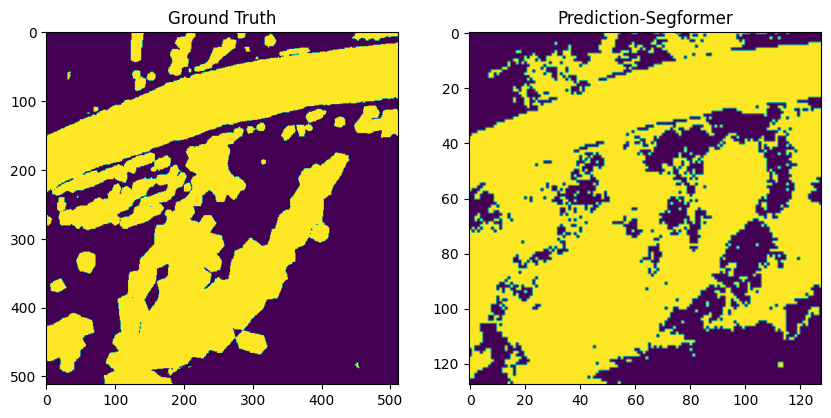

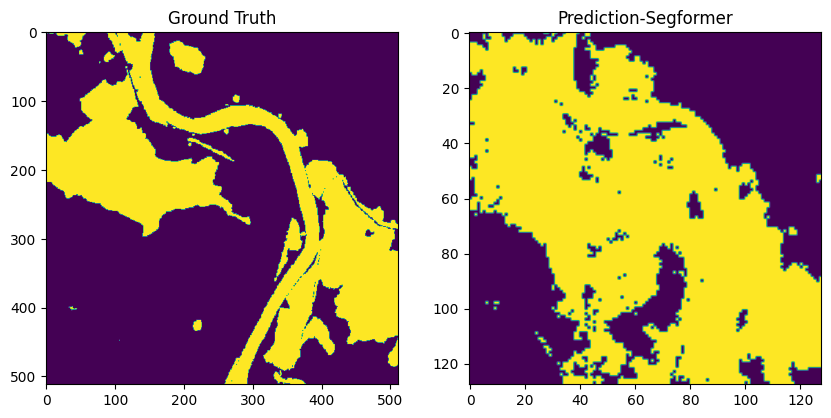

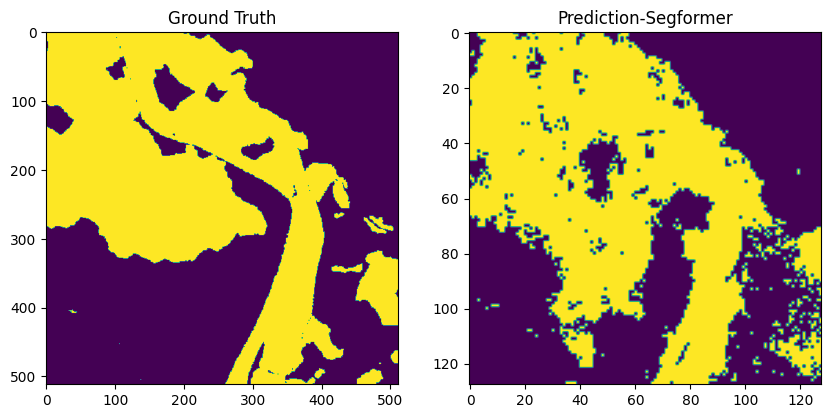

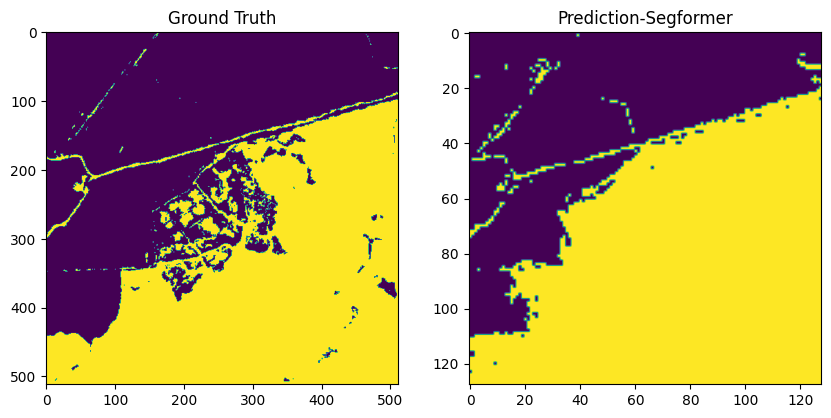

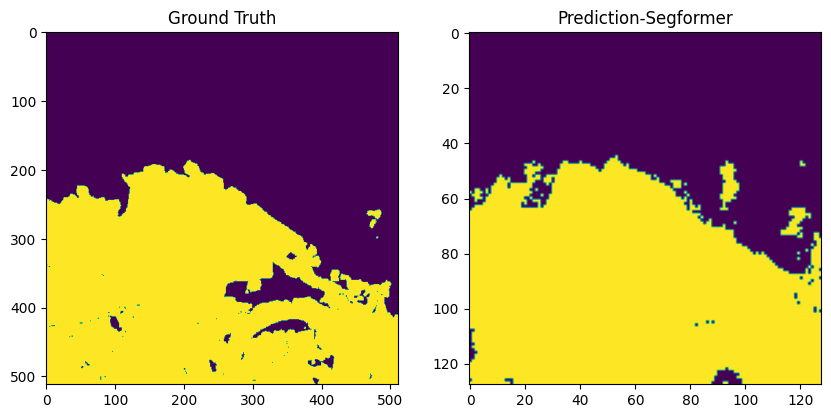

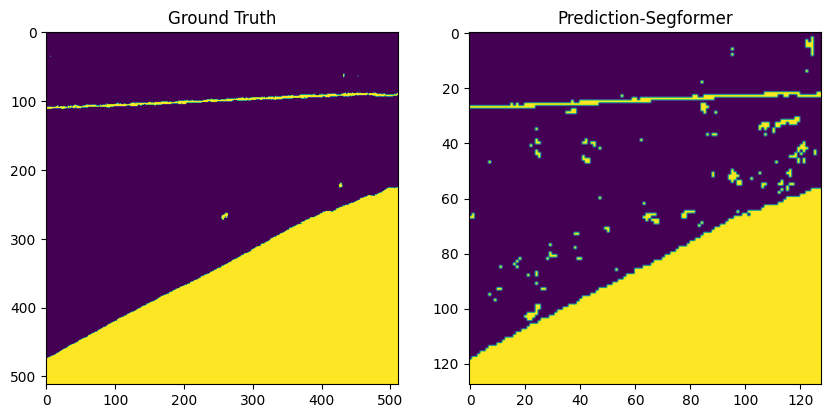

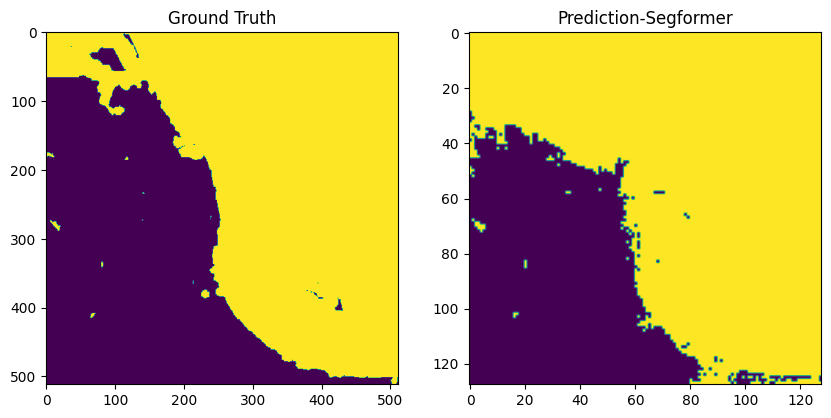

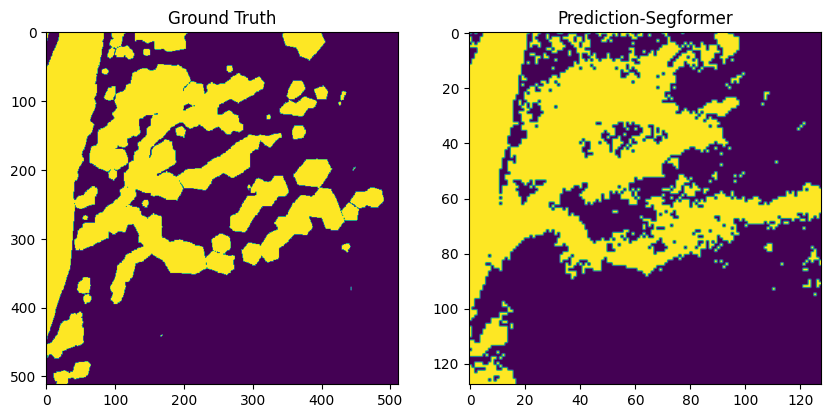

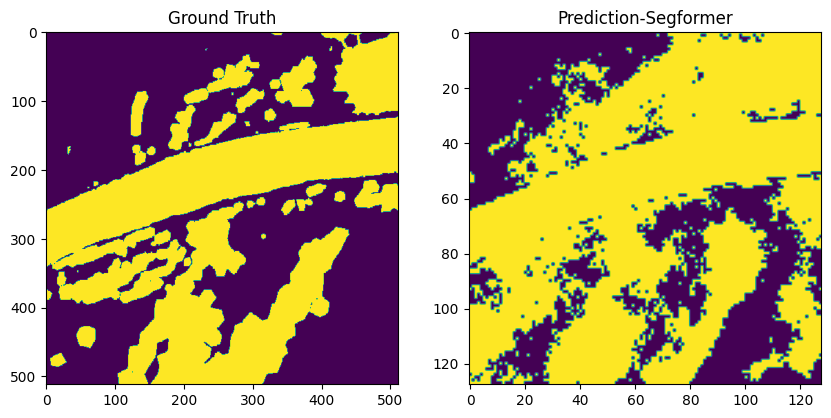

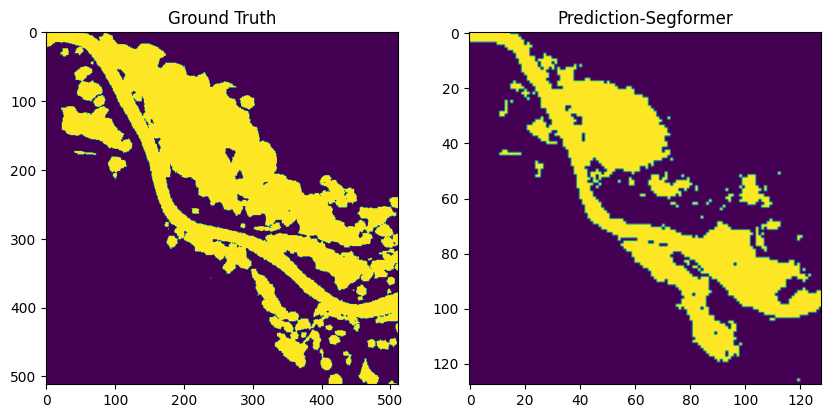

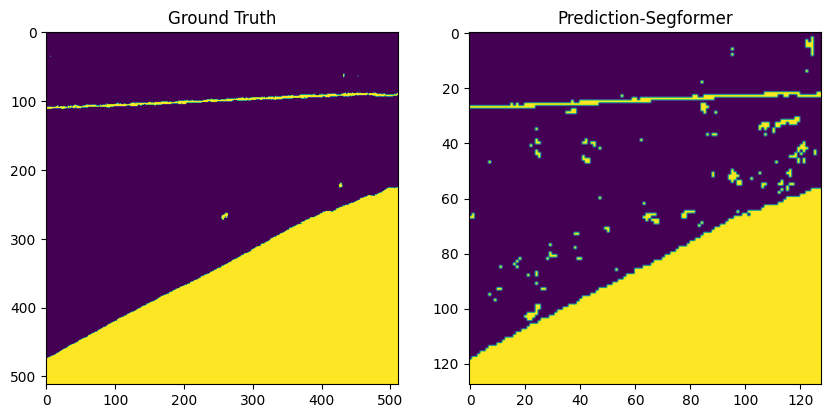

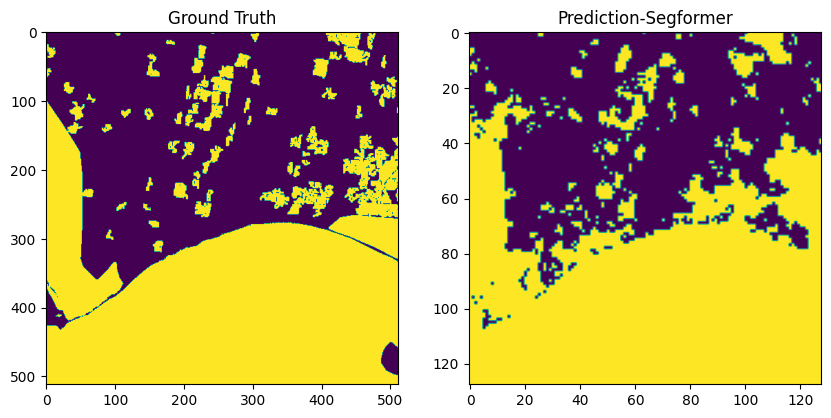

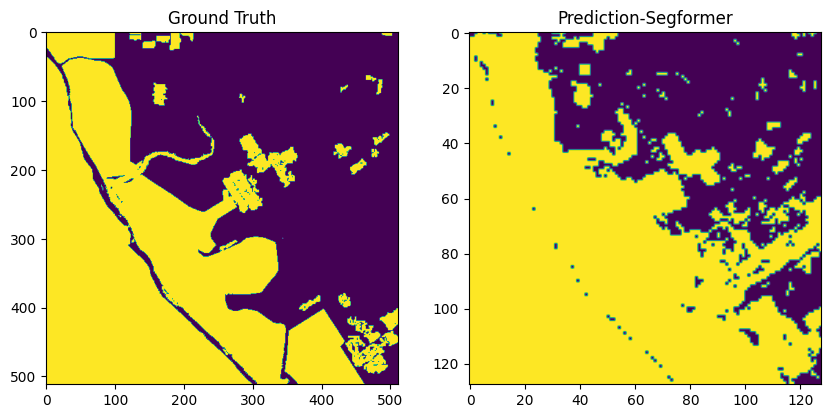

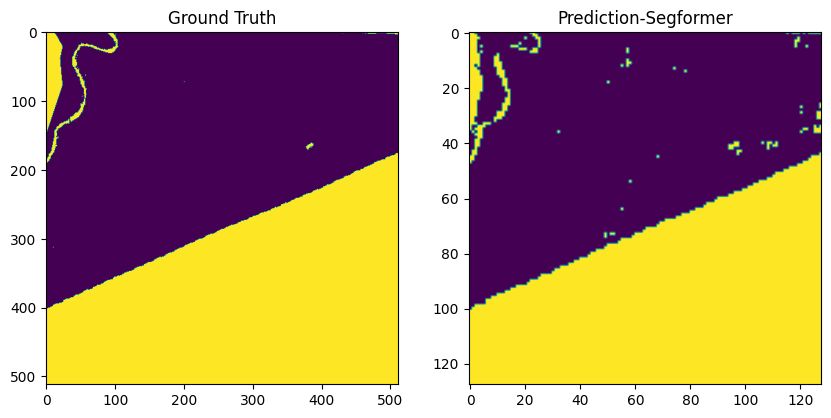

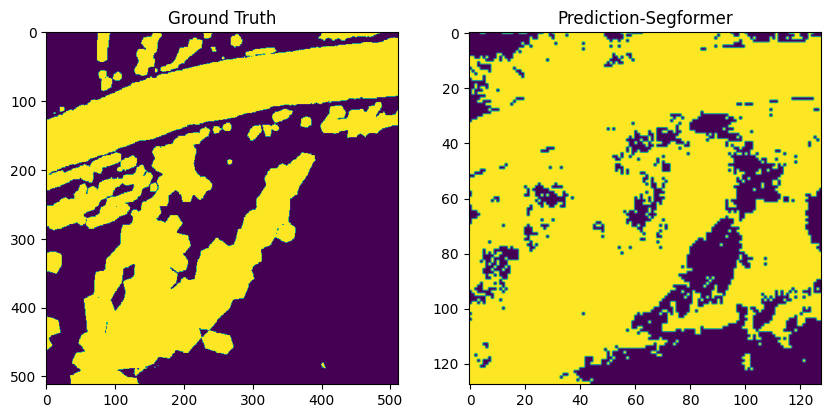

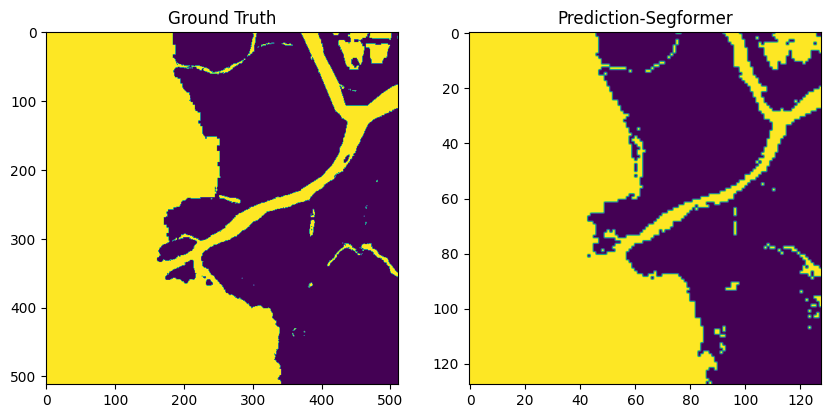

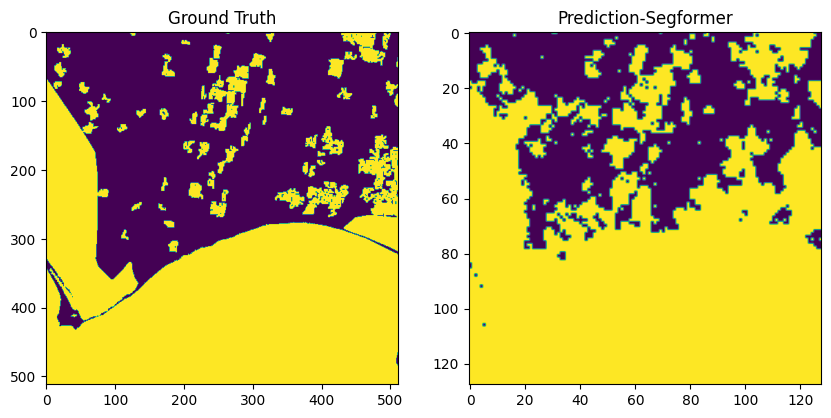

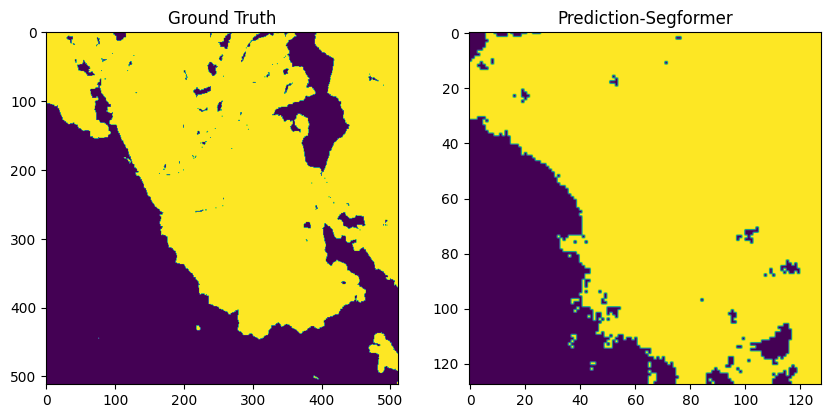

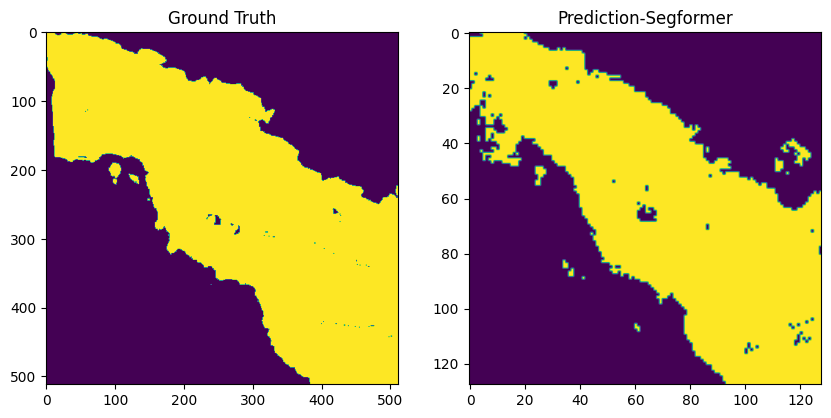

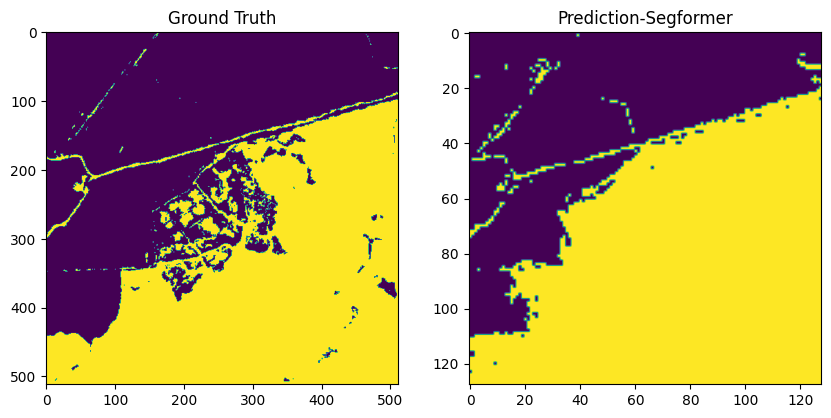

In [25]:

for i,j in zip(labels_2, file_names): #file_names is sorted
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    ground_truth = parse_mask(os.path.join(labels_dir, j.replace('.tif', '.png')))
    ax[0].imshow(ground_truth)   
    ax[0].set_title('Ground Truth')
    
    ax[1].imshow(i)
    ax[1].set_title('Prediction-Segformer')
    
    plt.show

In [ ]:
## PLOTTING EM ALL TOGETHER

In [ ]:
images_dir = r"/kaggle/input/track1/Track1/train/images/"
labels_dir = r"/kaggle/input/track1/Track1/train/labels/"
preds = r"/kaggle/input/predictions-bestmodels"
image = parse_image(os.path.join(images_dir, '1001.tif'))
label = parse_mask(os.path.join(labels_dir, '1001.png'))
pred1 = parse_mask(os.path.join(preds, 'segformer_1001.png'))
pred2 = parse_mask(os.path.join(preds, 'unet_1001.png'))
pred3 = parse_mask(os.path.join(preds, 'naive_1001.png'))

In [ ]:
# plot image's first band, band 4 and label in first row, and the prediction in the second row, add legend
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(image[:, :, 0], cmap='gray')
ax[0, 0].set_title('Image band 1')

ax[0, 1].imshow(image[:, :, 3], cmap='gray')
ax[0, 1].set_title('Image band 4')

ax[0, 2].imshow(label, cmap='gray')
ax[0, 2].set_title('Label')

ax[0, 3].imshow(pred1, cmap='gray')
ax[0, 3].set_title('Segformer')

ax[1, 0].imshow(pred2, cmap='gray')
ax[1, 0].set_title('Unet')

ax[1, 1].imshow(pred3, cmap='gray')
ax[1, 1].set_title('Naive')

for i in range(2):
    for j in range(4):
        ax[i, j].axis('off')

# legend
ax[0, 2].legend(['Building', 'Background'], loc='upper right')
ax[0, 3].legend(['Building', 'Background'], loc='upper right')
ax[1, 0].legend(['Building', 'Background'], loc='upper right')
ax[1, 1].legend(['Building', 'Background'], loc='upper right')


plt.show()

